##### Import the libraries

In [1]:
import os
import json
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import box_iou
from torchvision.ops import nms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_fscore_support
import rich
import numpy as np
from tqdm import tqdm

##### Transform to tensor

In [2]:
class FacadeDataset(Dataset):
    def __init__(self, image_dir, annotations_dir, transform=None):
        self.image_dir = image_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def load_annotations(self, annotation_file):
        with open(annotation_file) as f:
            data = json.load(f)
        
        boxes = []
        labels = []
        
        for shape in data["shapes"]:
            if shape["label"] == "window":
                points = shape["points"]
                
                # Calculate bounding box from polygon points
                x_coords = [p[0] for p in points]
                y_coords = [p[1] for p in points]
                x_min = min(x_coords)
                y_min = min(y_coords)
                x_max = max(x_coords)
                y_max = max(y_coords)
                
                # Bounding box format: [x_min, y_min, width, height]
                box = [x_min, y_min, x_max - x_min, y_max - y_min]
                boxes.append(box)
                labels.append(1)  # Use 1 for "window" category label

        return {"boxes": boxes, "labels": labels}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        annotation_path = os.path.join(self.annotations_dir, f"{os.path.splitext(img_name)[0]}.json")

        image = Image.open(img_path).convert("RGB")
        annotations = self.load_annotations(annotation_path)

        # Convert bounding boxes and labels to tensors
        boxes = torch.tensor(annotations["boxes"], dtype=torch.float32)
        labels = torch.tensor(annotations["labels"], dtype=torch.int64)

        if self.transform:  
            image = self.transform(image)

        target = {"boxes": boxes, "labels": labels}
        return image, target


# Define transformations
transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Directories for training
train_image_dir = os.path.join("ZJU_dataset_2", "images")
train_annotations_dir = os.path.join("ZJU_dataset_2", "annotation")

# Create dataset
dataset = FacadeDataset(train_image_dir, train_annotations_dir, transform=transform)

# print("Dataset :", dataset[0])

print("Dataset length:", len(dataset))

Dataset length: 250


##### Split the dataset

In [3]:
# Define the proportions for train, validation, and test
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Load the full dataset (assuming train_annotations includes all data at this stage)
full_dataset = FacadeDataset(train_image_dir, train_annotations_dir, transform=transform)

# Calculate lengths of each split
train_size = int(train_ratio * len(full_dataset))
val_size = int(val_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 175
Validation dataset size: 50
Test dataset size: 25


##### Prepare Data Loaders

In [4]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print("Train dataset:", len(train_dataset))
print("Validation dataset:", len(val_dataset))
print("Test dataset:", len(test_dataset))

Train dataset: 175
Validation dataset: 50
Test dataset: 25


##### Checking the input data

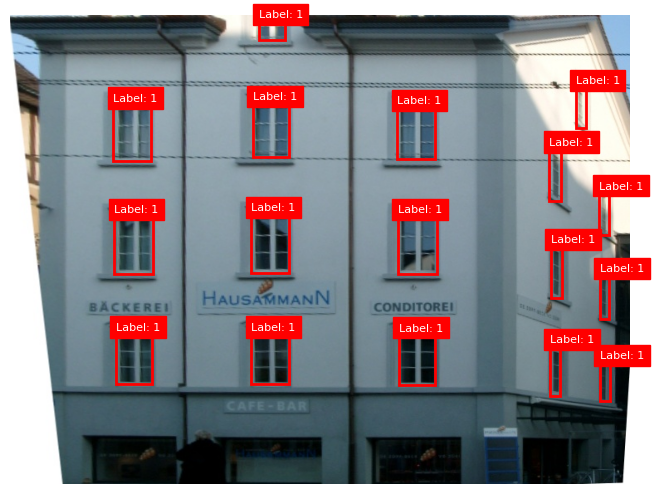

In [5]:
def visualize_sample(dataset, idx):
    # Retrieve image and target from dataset
    image, target = dataset[idx]
    boxes = target['boxes']
    labels = target['labels']
    
    # Convert the tensor image to a numpy array for visualization
    image = image.permute(1, 2, 0).numpy()  # Change shape from (C, H, W) to (H, W, C)

    # Plot the image
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    
    # Add bounding boxes
    for box, label in zip(boxes, labels):
        # Unpack the box coordinates
        xmin, ymin, width, height = box
        rect = patches.Rectangle(
            (xmin, ymin), width, height, linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)
        # Optional: Add label text if you have a mapping from `label` to class names
        ax.text(xmin, ymin, f"Label: {label.item()}", color="white", fontsize=8, backgroundcolor="red")
    
    plt.axis("off")
    plt.show()

# Test visualization with a sample from the train_dataset
visualize_sample(train_dataset, idx=45)  # Change idx to visualize other samples


##### Define The Model

In [6]:
# Define the model
num_classes = 2  # Change this to the number of classes you have (including background)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

##### Define a fucntion to convert the bounding boxes to x_min, y_min, x_max, y_max format instead of W, H

In [7]:
def convert_bounding_boxes(targets):
    for target in targets:
        boxes = target['boxes']
        converted_boxes = []
        for box in boxes:
            x_min, y_min, width, height = box
            x_max = x_min + width
            y_max = y_min + height
            converted_boxes.append([x_min, y_min, x_max, y_max])
        target['boxes'] = torch.tensor(converted_boxes, dtype=torch.float32)
    return targets

##### Check if Cuda is avaliable and what GPU does it use

In [8]:
# Check if CUDA is available and print the device being used
if torch.cuda.is_available():
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: NVIDIA GeForce GTX 1660 Ti


##### Hyper parameters tuning

In [11]:
def find_best_hyperparameters(
    model, 
    train_loader, 
    val_loader, 
    param_grid, 
    device='cuda', 
    num_epochs=1, 
    confidence_threshold=0.5
):
    """
    Find the best hyperparameters for the model using grid search.
    
    Parameters:
        model: The model to be trained and evaluated.
        train_loader: DataLoader for the training set.
        val_loader: DataLoader for the validation set.
        param_grid: Dictionary of hyperparameters to search. Example:
                    {
                        'lr': [0.001, 0.005],
                        'momentum': [0.9, 0.95],
                        'weight_decay': [0.0001, 0.0005]
                    }
        device: Device to use ('cuda' or 'cpu').
        num_epochs: Number of epochs for each hyperparameter combination.
        confidence_threshold: Confidence threshold for predictions.
    
    Returns:
        A dictionary with the best hyperparameters and their corresponding metrics.
    """
    from itertools import product
    import torch.optim as optim

    best_params = None
    best_metrics = None

    # Generate all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    for params in param_combinations:
        print(f"Testing hyperparameters: {params}")
        
        # Update model and optimizer
        model_copy = model.to(device)  # Ensure model is on the correct device
        optimizer = optim.SGD(
            model_copy.parameters(),
            lr=params['lr'],
            momentum=params['momentum'],
            weight_decay=params['weight_decay']
        )
        
        # Training loop (1 epoch per combination)
        model_copy.train()
        for epoch in range(num_epochs):
            for images, targets in train_loader:
                targets = convert_bounding_boxes(targets)
                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                optimizer.zero_grad()
                loss_dict = model_copy(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                losses.backward()
                optimizer.step()

        # Evaluation
        model_copy.eval()
        with torch.no_grad():
            all_precisions, all_recalls, all_f1s, ious = [], [], [], []

            for images, targets in val_loader:
                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                outputs = model_copy(images)
                pred_boxes = [output['boxes'].cpu() for output in outputs]
                pred_confidences = [output['scores'].cpu() for output in outputs]
                target_boxes = [target['boxes'].cpu() for target in targets]

                # Calculate metrics
                for pb, pc, tb in zip(pred_boxes, pred_confidences, target_boxes):
                    high_conf_mask = pc > confidence_threshold
                    pb = pb[high_conf_mask]
                    pc = pc[high_conf_mask]

                    if pb.size(0) > 0:
                        indices = nms(pb, pc, iou_threshold=0.5)
                        pb = pb[indices]

                    if pb.size(0) > 0 and tb.size(0) > 0:
                        iou = box_iou(pb, tb)
                        tp = (iou >= 0.5).sum().item()
                        fp = pb.size(0) - tp
                        fn = tb.size(0) - tp

                        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                        all_precisions.append(precision)
                        all_recalls.append(recall)
                        all_f1s.append(f1)

            mean_precision = sum(all_precisions) / len(all_precisions) if all_precisions else 0
            mean_recall = sum(all_recalls) / len(all_recalls) if all_recalls else 0
            mean_f1 = sum(all_f1s) / len(all_f1s) if all_f1s else 0

            metrics = {
                'precision': mean_precision,
                'recall': mean_recall,
                'f1': mean_f1
            }
        
        print(f"Metrics for {params}: {metrics}")

        if best_metrics is None or metrics['f1'] > best_metrics['f1']:
            best_params = params
            best_metrics = metrics

    print(f"Best hyperparameters: {best_params}")
    print(f"Best metrics: {best_metrics}")
    return {'best_params': best_params, 'best_metrics': best_metrics}


In [ ]:
param_grid = {
    'lr': [0.001, 0.005],
    'momentum': [0.9, 0.95],
    'weight_decay': [0.0001, 0.0005]
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_hyperparams = find_best_hyperparameters(model, train_loader, val_loader, param_grid, device=device)


##### early stopping functions

In [9]:
# Taken from https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.epoch = 0
        self.trace_func = trace_func
    def __call__(self, val_loss, epoch, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.epoch = epoch
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.epoch = epoch
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [10]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

##### train and evaluate the model

In [11]:
NUM_EPOCHS = 5

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

confidence_threshold = 0.5

Training:   1%|          | 1/88 [00:05<07:49,  5.40s/it]

Epoch: 0 Batch Index: 0 Loss: 3.059591293334961


Training:  58%|█████▊    | 51/88 [00:44<00:27,  1.33it/s]

Epoch: 0 Batch Index: 50 Loss: 0.5635815262794495


Validation Metrics - Epoch [1/5]
  Mean IoU: 0.4465
  Precision: 0.7845
  Recall: 0.9441
  F1 Score: 0.8437
Epoch #0 TRAIN LOSS: 0.6821403828534213 VALIDATION LOSS: 0.54880277633667

Validation loss decreased (inf --> 0.548803).  Saving model ...


Training:   1%|          | 1/88 [00:00<00:56,  1.54it/s]

Epoch: 1 Batch Index: 0 Loss: 0.5656000375747681


Training:  58%|█████▊    | 51/88 [00:39<00:33,  1.09it/s]

Epoch: 1 Batch Index: 50 Loss: 0.6227931976318359


Validation Metrics - Epoch [2/5]
  Mean IoU: 0.3797
  Precision: 0.6552
  Recall: 0.9583
  F1 Score: 0.7558
Epoch #1 TRAIN LOSS: 0.45953103832223197 VALIDATION LOSS: 0.42246108412742617

Validation loss decreased (0.548803 --> 0.422461).  Saving model ...


Training:   1%|          | 1/88 [00:00<01:10,  1.24it/s]

Epoch: 2 Batch Index: 0 Loss: 0.44395503401756287


Training:  58%|█████▊    | 51/88 [00:42<00:41,  1.12s/it]

Epoch: 2 Batch Index: 50 Loss: 0.4068238437175751


Validation Metrics - Epoch [3/5]
  Mean IoU: 0.5525
  Precision: 0.8069
  Recall: 0.9502
  F1 Score: 0.8583
Epoch #2 TRAIN LOSS: 0.34342067197642545 VALIDATION LOSS: 0.4119012689590454

Validation loss decreased (0.422461 --> 0.411901).  Saving model ...


Training:   1%|          | 1/88 [00:00<01:15,  1.15it/s]

Epoch: 3 Batch Index: 0 Loss: 0.18622702360153198


Training:  58%|█████▊    | 51/88 [00:44<00:41,  1.12s/it]

Epoch: 3 Batch Index: 50 Loss: 0.17719772458076477


Validation Metrics - Epoch [4/5]
  Mean IoU: 0.6112
  Precision: 0.7877
  Recall: 0.9077
  F1 Score: 0.8322
Epoch #3 TRAIN LOSS: 0.29221964381973853 VALIDATION LOSS: 0.3991819202899933

Validation loss decreased (0.411901 --> 0.399182).  Saving model ...


Training:   1%|          | 1/88 [00:00<01:16,  1.14it/s]

Epoch: 4 Batch Index: 0 Loss: 0.22665606439113617


Training:  58%|█████▊    | 51/88 [00:43<00:33,  1.10it/s]

Epoch: 4 Batch Index: 50 Loss: 0.304619163274765


Validation Metrics - Epoch [5/5]
  Mean IoU: 0.5719
  Precision: 0.7612
  Recall: 0.9170
  F1 Score: 0.8209
Epoch #4 TRAIN LOSS: 0.2615404287353158 VALIDATION LOSS: 0.4097631138563156

EarlyStopping counter: 1 out of 3


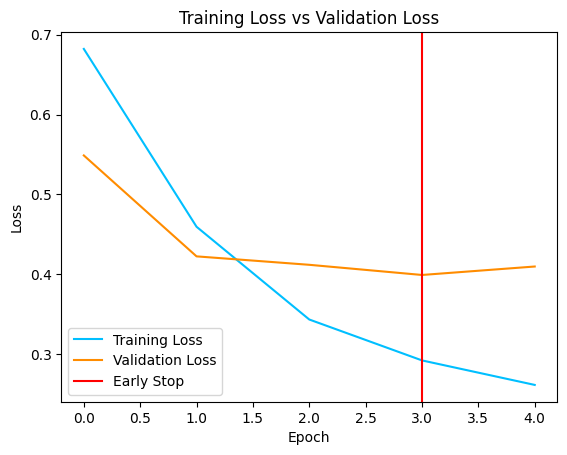

Training finished!


In [12]:
train_losses = Averager()
totalTrainLosses = []
val_losses = Averager()
totalValLosses = []
lowest_val_loss = float('inf')
early_stopping = EarlyStopping(patience = 3, path = "checkpoint.pth", verbose=True)
# has to be in train mode for both train and valid coz the outputs are different in two cases
for epoch in range(NUM_EPOCHS):
    train_losses.reset()
    val_losses.reset()
    model.train()
    # Progress bar for the training loop
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for batch_index, (images, targets) in enumerate(train_loader_tqdm):
        targets = convert_bounding_boxes(targets)
        # move the images and targets to device
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        # track the loss
        train_losses.send(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 50 == 0:
            print(f"Epoch: {epoch} Batch Index: {batch_index} Loss: {loss.item()}")

    # evaluate
    model.train()
    with torch.no_grad():
        # Progress bar for the validation loop
        val_loader_tqdm = tqdm(val_loader, desc="Validating loss", leave=False)
        for _, (images, targets) in enumerate(val_loader_tqdm):
            targets = convert_bounding_boxes(targets)
            # move the images and targets to device
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            val_loss_dict = model(images, targets)
            val_loss = sum(loss for loss in val_loss_dict.values())

            # track the loss
            val_losses.send(val_loss.item())

    # Metric Evaluation
    model.eval()
    with torch.no_grad():
        val_loader_tqdm = tqdm(val_loader, desc="Validating Metrics", leave=False)
        all_precisions, all_recalls, all_f1s, ious = [], [], [], []
        for _, (images, targets) in enumerate(val_loader_tqdm):
            images = [image.to(DEVICE) for image in images]
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            
            # Get predictions
            outputs = model(images)
            pred_boxes = [output['boxes'].cpu() for output in outputs]
            pred_confidences = [output['scores'].cpu() for output in outputs]
            targets = convert_bounding_boxes(targets)
            target_boxes = [target['boxes'].cpu() for target in targets]

            # print("Predicted Boxes:", pred_boxes)
            # print("targeted Boxes:", target_boxes)
            
            # Calculate IoU for each image
            batch_ious = []
            for pb, tb in zip(pred_boxes, target_boxes):
                if pb.size(0) > 0 and tb.size(0) > 0:
                    iou = box_iou(pb, tb)
                    batch_ious.append(iou.max(dim=1).values.mean().item())  # Mean IoU per prediction
            ious.extend(batch_ious)
            
            # Calculate precision, recall, F1 at IoU 0.5 threshold
            for pb, pc, tb in zip(pred_boxes, pred_confidences, target_boxes):
                # Step 1: Filter predictions by confidence
                high_conf_mask = pc > confidence_threshold
                pb = pb[high_conf_mask]
                pc = pc[high_conf_mask]
                
                # Step 2: Apply Non-Maximum Suppression (NMS)
                if pb.size(0) > 0:
                    indices = nms(pb, pc, iou_threshold=0.5)
                    pb = pb[indices]
                    pc = pc[indices]

                # Step 3: Calculate IoU and True Positives
                if pb.size(0) > 0 and tb.size(0) > 0:
                    iou = box_iou(pb, tb)
                    tp = (iou >= 0.5).sum().item()  # True positives at IoU=0.5
                    fp = pb.size(0) - tp  # False positives
                    fn = tb.size(0) - tp  # False negatives
                    
                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                    
                    all_precisions.append(precision)
                    all_recalls.append(recall)
                    all_f1s.append(f1)

        # Calculate mean metrics over the entire validation set
        mean_iou = sum(ious) / len(ious) if ious else 0
        mean_precision = sum(all_precisions) / len(all_precisions) if all_precisions else 0
        mean_recall = sum(all_recalls) / len(all_recalls) if all_recalls else 0
        mean_f1 = sum(all_f1s) / len(all_f1s) if all_f1s else 0

        print(f"Validation Metrics - Epoch [{epoch + 1}/{NUM_EPOCHS}]")
        print(f"  Mean IoU: {mean_iou:.4f}")
        print(f"  Precision: {mean_precision:.4f}")
        print(f"  Recall: {mean_recall:.4f}")
        print(f"  F1 Score: {mean_f1:.4f}")

    if val_losses.value >= lowest_val_loss and lr_scheduler is not None:
        lr_scheduler.step()

    # print stats
    print(f"Epoch #{epoch} TRAIN LOSS: {train_losses.value} VALIDATION LOSS: {val_losses.value}\n")
    totalTrainLosses.append(train_losses.value)
    totalValLosses.append(val_losses.value)
    early_stopping(val_losses.value, epoch, model)
    if early_stopping.early_stop:
        print("Early stopping!")
        break

plt.plot(totalTrainLosses, label = "Training Loss", color = "deepskyblue")
plt.plot(totalValLosses, label = "Validation Loss", color = "darkorange")
plt.axvline(early_stopping.epoch, label = "Early Stop", color = "red")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.show()
os.rename("checkpoint.pth", "fasterrcnn_checkpoint_2.pth")
print("Training finished!")

##### Define a function for visualizing the results (predicitons)

In [13]:
def visualize_predictions(predictions, image_tensor, threshold=0.5, class_names=None):
    """
    Visualizes predictions on an image.

    Args:
        predictions (dict): The predictions dictionary from Faster R-CNN, containing 'boxes', 'labels', and 'scores'.
        image_tensor (Tensor): The image tensor.
        threshold (float): Confidence threshold to filter boxes.
        class_names (list): List of class names, where index corresponds to class label (optional).
    """
    # Convert the tensor to a PIL image
    img = transforms.ToPILImage()(image_tensor.cpu())
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()

    # Draw each bounding box
    boxes = predictions['boxes']
    labels = predictions['labels']
    scores = predictions['scores']

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:  # Filter boxes by score
            x_min, y_min, x_max, y_max = box.detach().cpu().numpy()
            width, height = x_max - x_min, y_max - y_min

            # Draw the rectangle
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Get label name if provided, otherwise use label index
            label_text = class_names[label] if class_names else f"Class {label}"
            label_text = f"{label_text}: {score:.2f}"

            # Add label and score
            ax.text(x_min, y_min - 10, label_text, color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.show()

Visualizing predictions for image 6


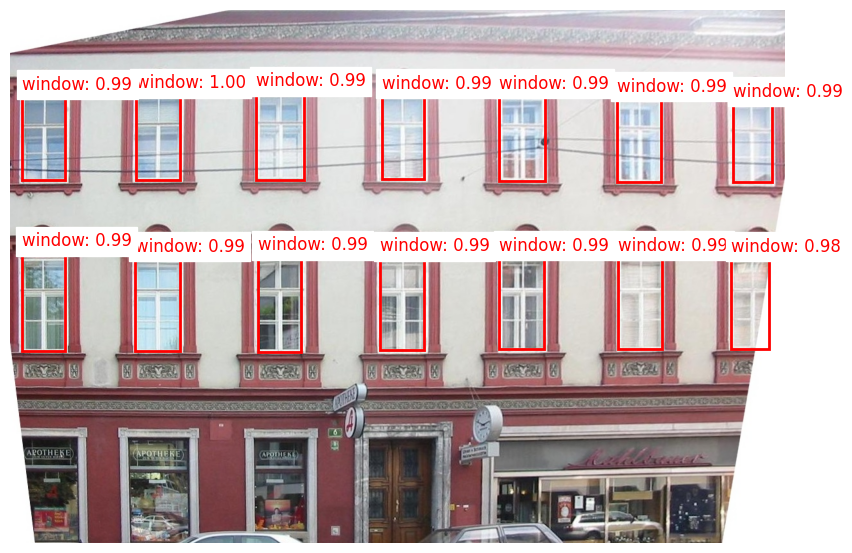

In [14]:
model.eval()
class_names = ["background", "window"]  # Add your class names here, with "background" as the first item
ind = 6  # Index of the image you want to visualize

with torch.no_grad():
    for batch_idx, (images, _) in enumerate(test_loader):
        images = [image.to(DEVICE) for image in images]
        predictions = model(images)

        # Check if the desired index is within this batch
        if ind >= batch_idx * len(images) and ind < (batch_idx + 1) * len(images):
            relative_index = ind - batch_idx * len(images)  # Relative index within the current batch
            print(f"Visualizing predictions for image {ind}")
            visualize_predictions(predictions[relative_index], images[relative_index], threshold=0.5, class_names=class_names)
            break  # Exit the loop after visualizing the desired image


##### save and load the model

In [ ]:
# Define the path to save the model
save_path = "fasterrcnn_checkpoint.pth"

# Save the model and optimizer state dictionaries
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch + 1,  # Save the last completed epoch
}, save_path)

print(f"Model saved to {save_path}")
